<a href="https://colab.research.google.com/github/RuthKassahun/Skin-Lesion-Classification/blob/main/Color_histogram_on_Hair_Removed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from pathlib import Path
import xgboost as xgb
import lightgbm as lgb
from PIL import Image, ImageOps
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, recall_score, confusion_matrix

In [2]:
def hist_features(img): 
  hist_blue = cv2.calcHist([img],[0],None,[256],[0,256]) #blue 
  hist_green = cv2.calcHist([img],[1],None,[256],[0,256]) 
  hist_red = cv2.calcHist([img],[2],None,[256],[0,256]) 
  hist=np.hstack([hist_green,hist_red,hist_blue]) 
  return hist.flatten()

In [15]:
#Resize images to 
SIZE = 224 
 
#Capture images and labels into arrays. 
#Start by creating empty lists. 
train_hist = [] 
train_label_hist = []  
for directory_path in glob.glob("/content/drive/MyDrive/CAD_PROJECT/hair_removed/train/*"): 
    labelhist = directory_path.split("\\")[-1] 
    label = directory_path.split("/")[-1]
    #print(labelhist) 
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")): 
        #print(img_path) 
        img3 = cv2.imread(img_path,cv2.COLOR_BGR2RGB) #Reading color images 
        img3 = cv2.resize(img3, (SIZE, SIZE)) #Resize images 
        img3=hist_features(img3) #call the function 
        train_hist.append(img3) 
        train_label_hist.append(labelhist) 
 
train_hist = np.array(train_hist) 
train_label_hist= np.array(train_label_hist)

'/content/drive/MyDrive/CAD_PROJECT/hair_removed/test/other'

In [16]:
test_hist = [] 
test_label_hist = []  
#for directory_path in glob.glob("cell_images/test/*"): 
for directory_path in glob.glob("/content/drive/MyDrive/CAD_PROJECT/hair_removed/test/*"):
    labelhist = directory_path.split("\\")[-1] 
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img4 = cv2.imread(img_path,cv2.COLOR_BGR2RGB) #Reading color images 
        img4 = cv2.resize(img4, (SIZE, SIZE)) #Resize images 
        img4=hist_features(img4) #call the function 
        test_hist.append(img4) 
        test_label_hist.append(labelhist) 

test_hist = np.array(test_hist)
test_label_hist = np.array(test_label_hist)

In [17]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_label_hist)
test_labels_encoded = le.transform(test_label_hist)
le.fit(train_label_hist)
train_labels_encoded = le.transform(train_label_hist)

In [18]:
x_train, y_train, x_test, y_test = train_hist, train_labels_encoded, test_hist, test_labels_encoded

In [19]:
X_for_ML =x_train
X_test_ML =x_test

##SVM

In [20]:
pipe1 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", SVC(class_weight='balanced', probability=True, kernel= 'rbf', gamma=0.01, C=100)) #radial basis function kernel
                 ])

In [21]:
pipe1.fit(X_for_ML,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier',
                 SVC(C=100, class_weight='balanced', gamma=0.01,
                     probability=True))])

Accuracy: 65.98%


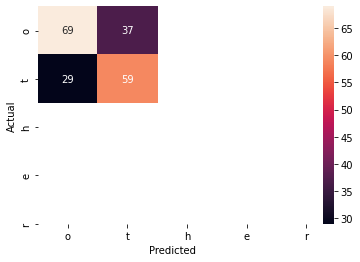

In [22]:
# Test set evaluation
prediction = pipe1.predict(X_test_ML)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [23]:
prediction_prob = pipe1.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.7456420068027211


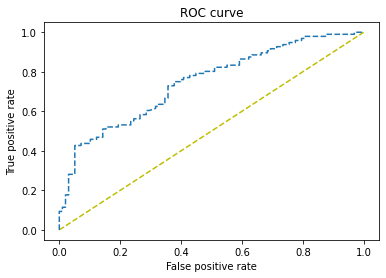

In [24]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## Random Forest

In [25]:
pipe2 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", RandomForestClassifier(n_estimators = 100, random_state = 42))
                 ])

In [26]:
pipe2.fit(X_for_ML,train_labels_encoded)


Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

Accuracy: 74.74%


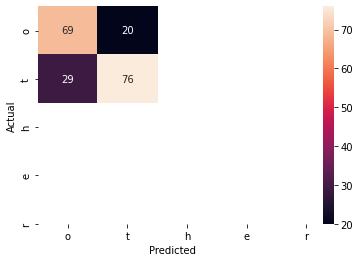

In [27]:
# Test set evaluation
prediction = pipe2.predict(X_test_ML)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [28]:
prediction_prob = pipe2.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.8333333333333334


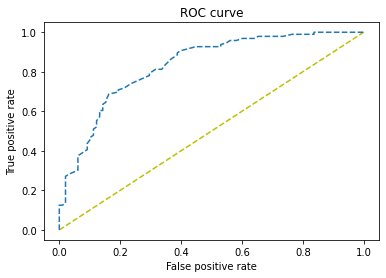

In [29]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## KNN

In [30]:
pipe3 = Pipeline([
                 ("scale",StandardScaler()),
                 ("classifier", KNeighborsClassifier(n_neighbors=7))
                 ])

In [31]:
pipe3.fit(X_for_ML,train_labels_encoded)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=7))])

In [32]:
prediction_prob = pipe3.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.6862244897959184


Accuracy: 63.40%


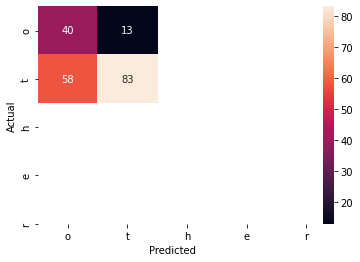

In [33]:
# Test set evaluation
prediction = pipe3.predict(X_test_ML)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

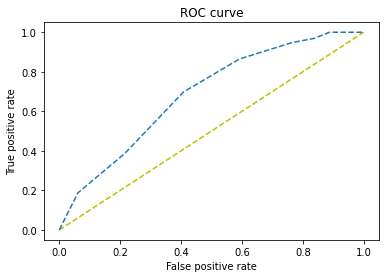

In [34]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## Ada Boost

In [35]:
clf = AdaBoostClassifier(n_estimators=200, random_state=0)
clf.fit(X_for_ML,train_labels_encoded)

AdaBoostClassifier(n_estimators=200, random_state=0)

In [36]:
prediction_prob = clf.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.7728528911564626


Accuracy: 71.13%


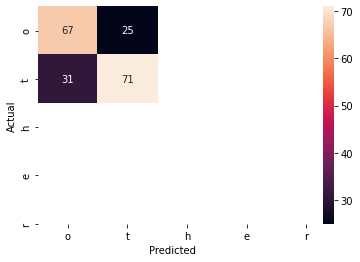

In [37]:
# Test set evaluation
prediction = clf.predict(X_test_ML)
# Visualization
cmat = confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

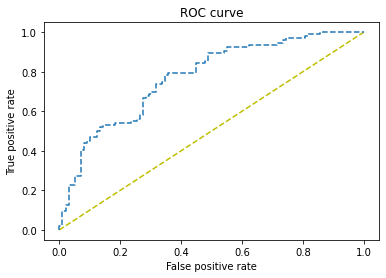

In [38]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## XGB

In [39]:
mod1 = xgb.XGBClassifier(booster='dart',learning_rate=0.1)
train_arr = np.array(X_for_ML)
test_arr = np.array(X_test_ML)
mod1.fit(train_arr, train_labels_encoded)

XGBClassifier(booster='dart')

In [40]:
prediction = mod1.predict(test_arr)
print("Accuracy = ", accuracy_score(test_labels_encoded, prediction))

Accuracy =  0.7164948453608248


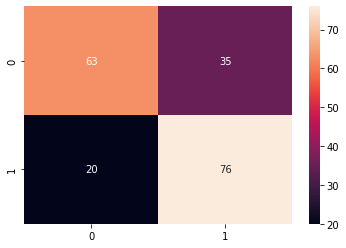

In [41]:
cm = confusion_matrix(test_labels_encoded, prediction)
sns.heatmap(cm, annot=True)

In [42]:
prediction_prob = mod1.predict_proba(test_arr)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.8232355442176871


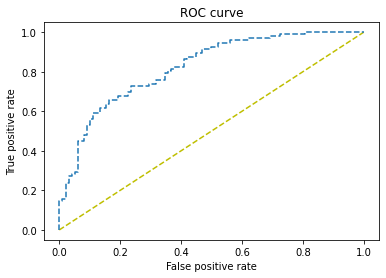

In [43]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## LightGBM

In [44]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_for_ML)
test_scaled = scaler.transform(X_test_ML)
d_train = lgb.Dataset(train_scaled, label=train_labels_encoded)

In [45]:
lgbm_params = {'learning_rate':0.05, 'boosting_type':'gbdt', #Sometimes dart gives better accuracy. gbdt means gradient boosting.
              'objective':'binary',
              'metric':['auc', 'binary_logloss'],
              'num_leaves':100, # optimizing this avoids overfitting. 50 to 100
              'max_depth':10} #10 may be appropriate

In [46]:
clf = lgb.train(lgbm_params, d_train, 50) #50 iterations. Increase iterations for small learning rates. eg if learning grate = 0.005, we may need 500 iterations.
prediction=clf.predict(test_scaled)
#convert the probabilities into binary values 0/1 for classification
for i in range(0, test_scaled.shape[0]):
    if prediction[i]>=.5: # setting threshold to 0.5
       prediction[i]=1
    else:  
       prediction[i]=0

Accuracy with LGBM =  0.7268041237113402


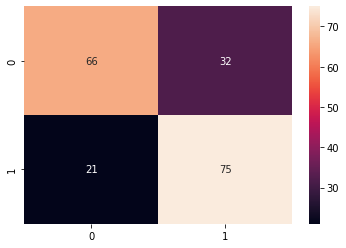

In [47]:
#Print accuracy
print ("Accuracy with LGBM = ", accuracy_score(test_labels_encoded, prediction))
#Confusion matrix
cm_lgbm = confusion_matrix(test_labels_encoded, prediction)
sns.heatmap(cm_lgbm, annot=True)

In [48]:
prediction_prob=clf.predict(test_scaled)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob))


Area under curve (AUC):  0.8291879251700681


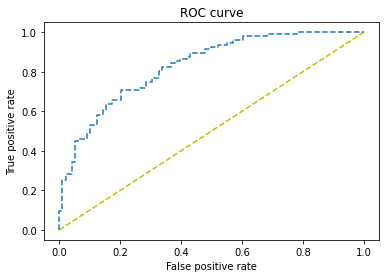

In [49]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()